In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/pediatric-pneumonia-chest-xray

100% 1.14G/1.14G [00:12<00:00, 112MB/s]
100% 1.14G/1.14G [00:12<00:00, 97.3MB/s]


In [ ]:
!unzip /content/pediatric-pneumonia-chest-xray.zip

Streaming output truncated to the last 5000 lines.
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0435-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0438-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0440-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0441-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0442-

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split

# Define transformations
transformations = Compose([
    Resize((128, 128)),
    ToTensor()
])

# Load the dataset
train_dataset = ImageFolder(root='/content/Pediatric Chest X-ray Pneumonia/train', transform=transformations)
test_dataset = ImageFolder(root='/content/Pediatric Chest X-ray Pneumonia/test', transform=transformations)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.nn as nn
device = "cuda"
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        features = self.conv_layers(x)
        x = features.view(features.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)
        return x

    def features(self, x):
        return self.conv_layers(x)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
device = "cuda"

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Additional conv layer
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Additional conv layer
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dropout = nn.Dropout(0.3)  # Dropout layer
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),  # Adjusted for added layers and pooling
            nn.ReLU(),
            nn.Dropout(0.2),  # Adding dropout to fully connected layers
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.dropout(x)  # Apply dropout before the fully connected layers
        x = self.fc_layers(x)
        return x

    def features(self, x):
        return self.conv_layers(x)
print(SimpleCNN())

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_layers): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    

In [ ]:
from torchsummary import summary
summary(SimpleCNN().to("cuda"),input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
          Dropout-13                 [-1, 8192]               0
           Linear-14                  [

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Load a pretrained ResNet model
        self.base_model = models.resnet18(pretrained=True)

        # Freeze all layers in the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer of the ResNet model to match our number of classes
        # ResNet's default last layer has 512 input features if using resnet18 or resnet34
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, 2)  # Assuming binary classification

    def forward(self, x):
        # Forward pass through the base model
        return self.base_model(x)

    def features(self, x):
        # Extract features from the last layer before the fully connected layer
        # We need to override the forward method of the base model to not include the final fc layer
        self.base_model.fc = nn.Identity()  # Temporarily remove the final layer
        features = self.base_model(x)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)  # Restore the final layer
        return features


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Load a pretrained ResNet model
        self.base_model = models.resnet18(pretrained=True)

        # Freeze all layers in the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Store the number of input features to the final FC layer
        self.num_features = self.base_model.fc.in_features

        # Replace the final fully connected layer of the ResNet model to match our number of classes
        self.base_model.fc = nn.Linear(self.num_features, 2)  # Assuming binary classification

    def forward(self, x):
        # Forward pass through the base model
        return self.base_model(x)

    def features(self, x):
        # Extract features from the last layer before the fully connected layer
        original_fc = self.base_model.fc  # Store the original fc layer
        self.base_model.fc = nn.Identity()  # Temporarily remove the final layer
        features = self.base_model(x)
        self.base_model.fc = original_fc  # Restore the original fc layer
        return features


In [ ]:
# Initialize the model, loss criterion, and optimizer
import torch.optim as optim
import torch
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    train_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_corrects += torch.sum(outputs.argmax(1) == labels).item()
        train_samples += labels.size(0)

    train_loss = train_loss / train_samples
    train_acc = train_corrects / train_samples

    # Validation phase
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    test_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            test_corrects += torch.sum(outputs.argmax(1) == labels).item()
            test_samples += labels.size(0)

    test_loss = test_loss / test_samples
    test_acc = test_corrects / test_samples

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Epoch 1/10, Train Loss: 0.3699, Train Accuracy: 0.8238, Test Loss: 0.5581, Test Accuracy: 0.7516
Epoch 2/10, Train Loss: 0.1429, Train Accuracy: 0.9450, Test Loss: 0.5334, Test Accuracy: 0.8221
Epoch 3/10, Train Loss: 0.1126, Train Accuracy: 0.9558, Test Loss: 0.7177, Test Accuracy: 0.7660
Epoch 4/10, Train Loss: 0.0959, Train Accuracy: 0.9629, Test Loss: 0.9948, Test Accuracy: 0.7548
Epoch 5/10, Train Loss: 0.0737, Train Accuracy: 0.9709, Test Loss: 0.8667, Test Accuracy: 0.7804
Epoch 6/10, Train Loss: 0.0700, Train Accuracy: 0.9748, Test Loss: 1.4693, Test Accuracy: 0.7244
Epoch 7/10, Train Loss: 0.0602, Train Accuracy: 0.9761, Test Loss: 1.5605, Test Accuracy: 0.7484
Epoch 8/10, Train Loss: 0.0515, Train Accuracy: 0.9795, Test Loss: 1.1787, Test Accuracy: 0.7532
Epoch 9/10, Train Loss: 0.0446, Train Accuracy: 0.9826, Test Loss: 1.5083, Test Accuracy: 0.7035
Epoch 10/10, Train Loss: 0.0514, Train Accuracy: 0.9801, Test Loss: 1.3391, Test Accuracy: 0.7452


In [ ]:
device = "cuda"
model = SimpleCNN().to(device)
model.eval()  # Set the model to evaluation mode

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_layers): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    

In [ ]:
BATCH_SIZE = 8  # Number of images to synthesize at once
IMAGE_SIZE = (3, 128, 128)  # Adjusted to your new expected input size
LEARNING_RATE = 0.05
NOISE_MEAN = 0
NOISE_STD = 1
NUM_ITERATIONS = 1000  # Number of iterations for optimization
TARGET_CLASS = 1  # Specify the target class (adjust as needed)

In [ ]:
def feature_distribution_regularization(model, synthesized_images):
    regularization_loss = 0
    for layer in model.conv_layers:
        if isinstance(layer, nn.BatchNorm2d):
            # Compute feature maps for the synthesized images
            with torch.no_grad():
                feature_maps = layer(synthesized_images)

            # Get the running mean and variance
            running_mean = layer.running_mean
            running_var = layer.running_var

            # Calculate the feature distribution regularization loss
            synthesized_mean = torch.mean(feature_maps, dim=[0, 2, 3])
            synthesized_var = torch.var(feature_maps, dim=[0, 2, 3])
            regularization_loss += torch.norm(synthesized_mean - running_mean) + torch.norm(synthesized_var - running_var)
    return regularization_loss

In [ ]:
def image_prior_regularization(synthesized_images):
    # Total variation and L2 norm regularization
    tv_loss = torch.sum(torch.abs(synthesized_images[:, :, :-1] - synthesized_images[:, :, 1:])) + \
              torch.sum(torch.abs(synthesized_images[:, :-1, :] - synthesized_images[:, 1:, :]))

    l2_loss = torch.norm(synthesized_images)

    return tv_loss + 0.01 * l2_loss

Iteration 0, Loss: 36893.80859375
Iteration 100, Loss: 11815.109375
Iteration 200, Loss: 10262.0126953125
Iteration 300, Loss: 8829.068359375
Iteration 400, Loss: 7512.630859375
Iteration 500, Loss: 6308.8515625
Iteration 600, Loss: 5215.4912109375
Iteration 700, Loss: 4224.52490234375
Iteration 800, Loss: 3331.706298828125
Iteration 900, Loss: 2532.02197265625
Iteration 1000, Loss: 1819.543701171875
Iteration 1100, Loss: 1231.02099609375
Iteration 1200, Loss: 786.0188598632812
Iteration 1300, Loss: 495.4439392089844
Iteration 1400, Loss: 327.1534423828125
Iteration 1500, Loss: 236.16525268554688
Iteration 1600, Loss: 184.41610717773438
Iteration 1700, Loss: 150.88381958007812
Iteration 1800, Loss: 126.00053405761719
Iteration 1900, Loss: 106.53590393066406
Iteration 2000, Loss: 90.93270874023438
Iteration 2100, Loss: 78.30064392089844
Iteration 2200, Loss: 67.91407775878906
Iteration 2300, Loss: 59.39188003540039
Iteration 2400, Loss: 52.3814811706543
Iteration 2500, Loss: 46.49227523

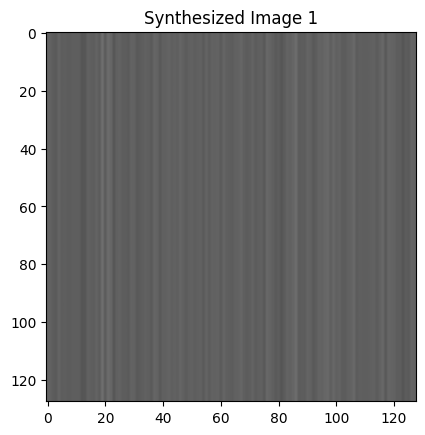

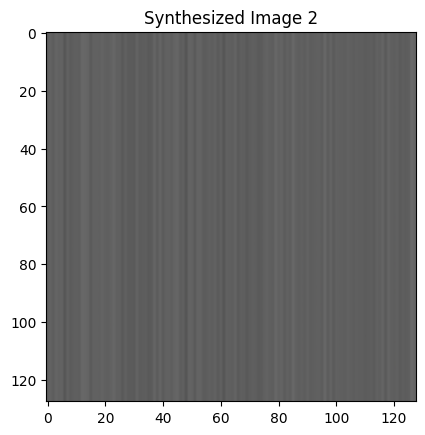

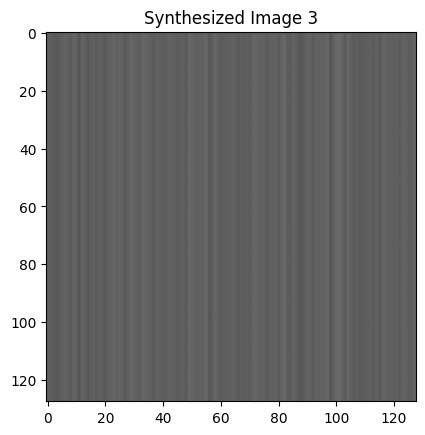

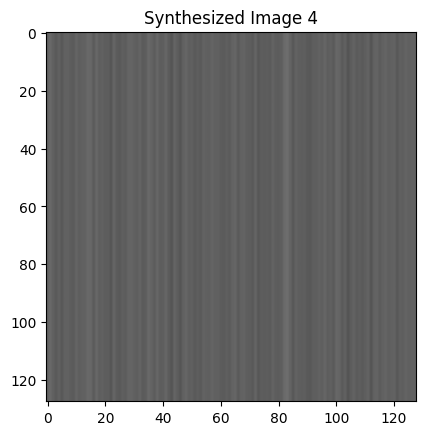

In [ ]:
import matplotlib.pyplot as plt
NUM_ITERATIONS = 10000
BATCH_SIZE = 4  # Number of images to synthesize at once
IMAGE_SIZE = (3, 128, 128)  # Adjusted to your new expected input size
LEARNING_RATE = 0.0005
NOISE_MEAN = 0
NOISE_STD = 1
NUM_ITERATIONS = 20000  # Number of iterations for optimization
TARGET_CLASS = 1  # Specify the target class (adjust as needed)
def feature_distribution_regularization(model, synthesized_images):
    regularization_loss = 0
    for layer in model.conv_layers:
        if isinstance(layer, nn.BatchNorm2d):
            # Compute feature maps for the synthesized images
            with torch.no_grad():
                feature_maps = layer(synthesized_images)

            # Get the running mean and variance
            running_mean = layer.running_mean
            running_var = layer.running_var

            # Calculate the feature distribution regularization loss
            synthesized_mean = torch.mean(feature_maps, dim=[0, 2, 3])
            synthesized_var = torch.var(feature_maps, dim=[0, 2, 3])
            regularization_loss += torch.norm(synthesized_mean - running_mean) + torch.norm(synthesized_var - running_var)
    return regularization_loss

# Define a prior regularization term for image smoothness
def image_prior_regularization(synthesized_images):
    # Total variation and L2 norm regularization
    tv_loss = torch.sum(torch.abs(synthesized_images[:, :, :-1] - synthesized_images[:, :, 1:])) + \
              torch.sum(torch.abs(synthesized_images[:, :-1, :] - synthesized_images[:, 1:, :]))

    l2_loss = torch.norm(synthesized_images)

    return tv_loss + 0.01 * l2_loss  # Total variation + L2 regularization with weighting factors

# Function to synthesize images from random noise
def synthesize_images(model, target_class, num_iterations):
    # Initialize random noise as the input
    synthesized_images = torch.randn((BATCH_SIZE, *IMAGE_SIZE), requires_grad=True, device=device)
    optimizer = optim.Adam([synthesized_images], lr=LEARNING_RATE)

    for i in range(num_iterations):
        optimizer.zero_grad()

        # Forward pass through the model
        logits = model(synthesized_images)

        # Compute loss with cross-entropy for the target class
        cross_entropy_loss = nn.CrossEntropyLoss()(logits, torch.tensor([target_class] * BATCH_SIZE, device=device))

        # Compute regularization terms
        feature_reg_loss = feature_distribution_regularization(model, synthesized_images)
        image_reg_loss = image_prior_regularization(synthesized_images)

        # Total loss
        total_loss = cross_entropy_loss + 0.1 * feature_reg_loss + 0.1 * image_reg_loss

        total_loss.backward()  # Backward propagation for optimization
        optimizer.step()  # Update synthesized images

        # Clamp synthesized images to ensure valid pixel values
        synthesized_images.data = synthesized_images.data.clamp(0, 1)

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {total_loss.item()}")

    return synthesized_images.detach().cpu()  # Return detached tensor to avoid memory leaks

# Synthesize images for the specified target class
synthesized_images = synthesize_images(model, TARGET_CLASS, NUM_ITERATIONS)

# Display the synthesized images
for i in range(min(5, BATCH_SIZE)):
    img = synthesized_images[i].numpy().transpose((1, 2, 0))  # (C, H, W) to (H, W, C)
    plt.imshow(img)
    plt.title(f"Synthesized Image {i+1}")
    plt.show()

In [ ]:
# Define the dataset loader to calculate mean and variance
transformations = Compose([Resize((128, 128)), ToTensor()])
train_dataset = ImageFolder(root='/content/Pediatric Chest X-ray Pneumonia/train', transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Calculate the mean and variance for the training dataset
def calculate_mean_variance(loader):
    mean = torch.zeros(3)
    var = torch.zeros(3)
    count = 0
    for data, _ in loader:
        batch_size = data.size(0)
        data = data.view(batch_size, 3, -1)  # Flatten to (N, C, H*W)
        mean += torch.mean(data, dim=[0, 2])
        var += torch.var(data, dim=[0, 2])
        count += 1
    mean /= count
    var /= count
    return mean, var

mean, variance = calculate_mean_variance(train_loader)
print("Dataset Mean:", mean)
print("Dataset Variance:", variance)



# Define a regularization term for feature distribution using dataset statistics
def feature_distribution_regularization(mean, variance, synthesized_images):
    regularization_loss = 0
    feature_maps = synthesized_images.view(synthesized_images.size(0), 3, -1)

    # Calculate mean and variance of synthesized images
    synthesized_mean = torch.mean(feature_maps, dim=[0, 2])
    synthesized_var = torch.var(feature_maps, dim=[0, 2])

    # Compute regularization loss based on dataset statistics
    regularization_loss += torch.norm(synthesized_mean - mean)
    regularization_loss += torch.norm(synthesized_var - variance)

    return regularization_loss

# Function to synthesize images with the new regularization
def synthesize_images(model, target_class, num_iterations):
    synthesized_images = torch.randn((8, 3, 128, 128), requires_grad=True, device='cuda')  # Smaller batch size for stability
    optimizer = optim.Adam([synthesized_images], lr=0.01)

    for i in range(num_iterations):
        optimizer.zero_grad()

        logits = model(synthesized_images)
        cross_entropy_loss = F.cross_entropy(logits, torch.tensor([target_class] * 8, device='cuda'))

        # Compute feature distribution regularization using dataset mean and variance
        feature_reg_loss = feature_distribution_regularization(mean, variance, synthesized_images)
        total_loss = cross_entropy_loss + 0.2 * feature_reg_loss

        total_loss.backward()
        optimizer.step()

        synthesized_images.data.clamp_(0, 1)

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {total_loss.item()}")

    return synthesized_images.detach().cpu()

# Synthesize images with the new regularization
synthesized_images = synthesize_images(SimpleCNN(), TARGET_CLASS, 1000)

# Display the synthesized images
for i in range(5):
    img = synthesized_images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(f"Synthesized Image {i+1}")
    plt.show()

Dataset Mean: tensor([0.4825, 0.4825, 0.4825])
Dataset Variance: tensor([0.0553, 0.0553, 0.0553])


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
def calculate_mean_variance(loader):
    mean = torch.zeros(3).to(device)  # Move to device
    var = torch.zeros(3).to(device)  # Move to device
    count = 0
    for data, _ in loader:
        data = data.to(device)  # Ensure data is on the correct device
        batch_size = data.size(0)
        data = data.view(batch_size, 3, -1)  # Flatten to (N, C, H*W)
        mean += torch.mean(data, dim=[0, 2])
        var += torch.var(data, dim=[0, 2])
        count += 1
    mean /= count
    var /= count
    return mean, var

mean, variance = calculate_mean_variance(train_loader)
print("Dataset Mean:", mean)
print("Dataset Variance:", variance)

# Define a regularization term for feature distribution using dataset statistics
def feature_distribution_regularization(mean, variance, synthesized_images):
    regularization_loss = 0
    feature_maps = synthesized_images.view(synthesized_images.size(0), 3, -1)  # Flatten feature maps

    # Calculate mean and variance of synthesized images
    synthesized_mean = torch.mean(feature_maps, dim=[0, 2])
    synthesized_var = torch.var(feature_maps, dim=[0, 2])

    # Compute regularization loss based on dataset statistics
    regularization_loss += torch.norm(synthesized_mean - mean)
    regularization_loss += torch.norm(synthesized_var - variance)

    return regularization_loss

# Function to synthesize images with the correct device context
def synthesize_images(model, target_class, num_iterations):
    # Initialize noise with the correct device context
    synthesized_images = torch.randn((8, 3, 128, 128), requires_grad=True, device=device)  # Ensure device match
    optimizer = optim.Adam([synthesized_images], lr=0.001)

    for i in range(num_iterations):
        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass through the model
        logits = model(synthesized_images)
        cross_entropy_loss = F.cross_entropy(logits, torch.tensor([target_class] * 8, device=device))  # Ensure target tensor is on the correct device

        # Compute regularization loss using dataset statistics
        feature_reg_loss = feature_distribution_regularization(mean, variance, synthesized_images)
        total_loss = cross_entropy_loss + 0.2 * feature_reg_loss  # Adjusted regularization coefficient

        total_loss.backward()  # Backward propagation for optimization
        optimizer.step()  # Update synthesized images

        synthesized_images.data.clamp_(0, 1)  # Clamp to valid pixel values

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {total_loss.item()}")

    return synthesized_images.detach().cpu()  # Detach and move to CPU for display

# Synthesize images with the correct device context
synthesized_images = synthesize_images(model, TARGET_CLASS, 10000)  # Ensure consistent device

# Display the synthesized images
for i in range(5):
    img = synthesized_images[i].numpy().transpose((1, 2, 0))  # (C, H, W) to (H, W, C)
    plt.imshow(img)
    plt.title(f"Synthesized Image {i+1}")
    plt.show()

Iteration 0, Loss: 1.1976360082626343
Iteration 100, Loss: 0.7093260288238525
Iteration 200, Loss: 0.6854580044746399
Iteration 300, Loss: 0.6790977120399475
Iteration 400, Loss: 0.6757569909095764
Iteration 500, Loss: 0.6736669540405273
Iteration 600, Loss: 0.6722018122673035
Iteration 700, Loss: 0.6711940765380859
Iteration 800, Loss: 0.6704362034797668
Iteration 900, Loss: 0.6697711944580078
Iteration 1000, Loss: 0.6692882180213928
Iteration 1100, Loss: 0.6688699722290039
Iteration 1200, Loss: 0.668531060218811
Iteration 1300, Loss: 0.6683220863342285
Iteration 1400, Loss: 0.6680126190185547
Iteration 1500, Loss: 0.6678975820541382
Iteration 1600, Loss: 0.667607843875885
Iteration 1700, Loss: 0.6674395203590393
Iteration 1800, Loss: 0.6672680377960205
Iteration 1900, Loss: 0.6670913100242615
Iteration 2000, Loss: 0.6669848561286926
Iteration 2100, Loss: 0.666911244392395
Iteration 2200, Loss: 0.6667471528053284
Iteration 2300, Loss: 0.6666809916496277
Iteration 2400, Loss: 0.6665849

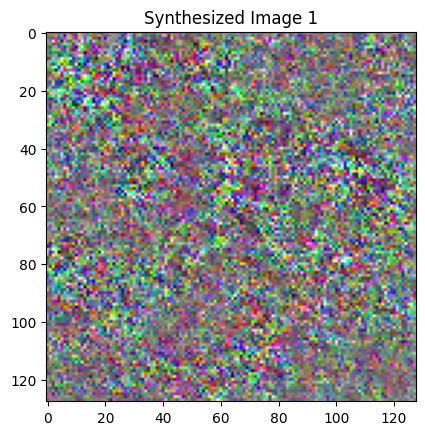

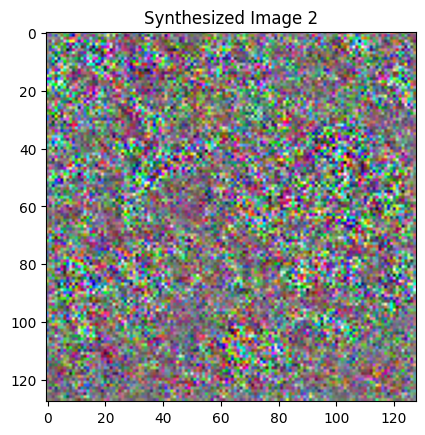

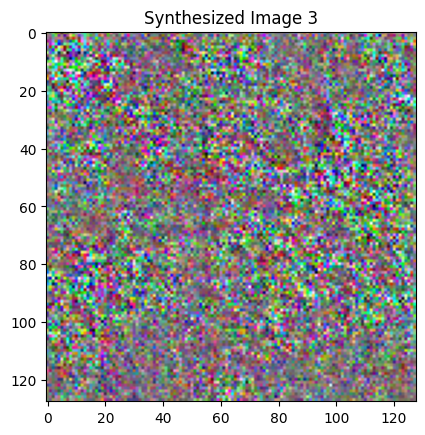

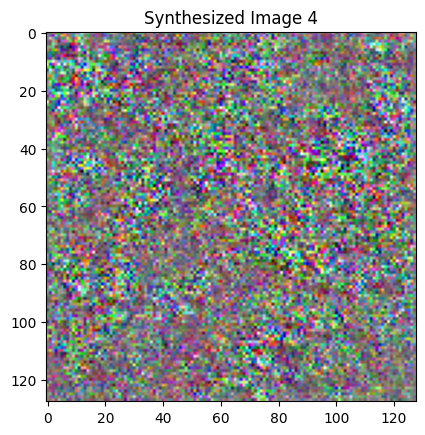

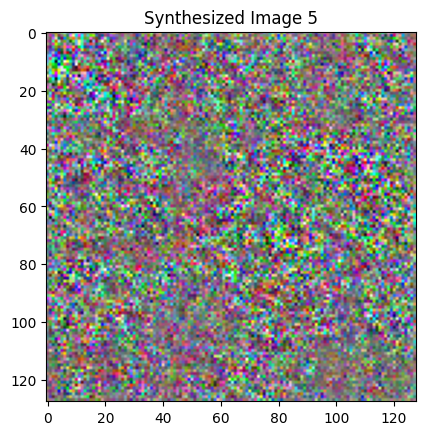

In [ ]:
# Define a regularization term for feature distribution using dataset statistics
def feature_distribution_regularization(mean, variance, synthesized_images):
    regularization_loss = 0
    feature_maps = synthesized_images.view(synthesized_images.size(0), 3, -1)  # Flatten feature maps

    # Calculate mean and variance of synthesized images
    synthesized_mean = torch.mean(feature_maps, dim=[0, 2])
    synthesized_var = torch.var(feature_maps, dim=[0, 2])

    # Compute regularization loss based on dataset statistics
    regularization_loss += torch.norm(synthesized_mean - mean)
    regularization_loss += torch.norm(synthesized_var - variance)

    return regularization_loss

# Function to synthesize images with the correct device context
def synthesize_images(model, target_class, num_iterations):
    # Initialize noise with the correct device context
    synthesized_images = torch.randn((8, 3, 128, 128), requires_grad=True, device=device)  # Ensure device match
    optimizer = optim.Adam([synthesized_images], lr=0.003)

    for i in range(num_iterations):
        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass through the model
        logits = model(synthesized_images)
        cross_entropy_loss = F.cross_entropy(logits, torch.tensor([target_class] * 8, device=device))  # Ensure target tensor is on the correct device

        # Compute regularization loss using dataset statistics
        feature_reg_loss = feature_distribution_regularization(mean, variance, synthesized_images)
        total_loss = cross_entropy_loss + 0.2 * feature_reg_loss  # Adjusted regularization coefficient

        total_loss.backward()  # Backward propagation for optimization
        optimizer.step()  # Update synthesized images

        synthesized_images.data.clamp_(0, 1)  # Clamp to valid pixel values

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {total_loss.item()}")

    return synthesized_images.detach().cpu()  # Detach and move to CPU for display

# Synthesize images with the correct device context
synthesized_images = synthesize_images(model, TARGET_CLASS, 10000)  # Ensure consistent device

# Display the synthesized images
for i in range(5):
    img = synthesized_images[i].numpy().transpose((1, 2, 0))  # (C, H, W) to (H, W, C)
    plt.imshow(img)
    plt.title(f"Synthesized Image {i+1}")
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.stats import entropy

# Define Jensen-Shannon Divergence
def jensen_shannon_divergence(p, q):
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

# Define a regularization term for feature distribution using dataset statistics
def feature_distribution_regularization(mean, variance, synthesized_images):
    regularization_loss = 0
    feature_maps = synthesized_images.view(synthesized_images.size(0), 3, -1)  # Flatten feature maps

    # Calculate mean and variance of synthesized images
    synthesized_mean = torch.mean(feature_maps, dim=[0, 2])
    synthesized_var = torch.var(feature_maps, dim=[0, 2])

    # Compute regularization loss based on dataset statistics
    regularization_loss += torch.norm(synthesized_mean - mean)
    regularization_loss += torch.norm(synthesized_var - variance)

    return regularization_loss

# Define adaptive regularization using JS divergence
def adaptive_regularization(teacher, student, synthesized_images):
    with torch.no_grad():
        teacher_logits = F.softmax(teacher(synthesized_images), dim=1)  # Get probabilities from teacher
        student_logits = F.softmax(student(synthesized_images), dim=1)  # Get probabilities from student

    # Compute Jensen-Shannon divergence
    js_divergence = 0
    for i in range(teacher_logits.size(0)):
        js_divergence += jensen_shannon_divergence(teacher_logits[i].cpu().numpy(), student_logits[i].cpu().numpy())

    return js_divergence

# Function to synthesize images with adaptive regularization
def synthesize_images(teacher, student, target_class, num_iterations):
    # Initialize noise as a leaf tensor
    synthesized_images = torch.randn((8, 3, 128, 128), requires_grad=True, device=device)  # Ensure leaf tensor
    optimizer = optim.Adam([synthesized_images], lr=0.003)

    for i in range(num_iterations):
        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass through the teacher model
        teacher_logits = teacher(synthesized_images)

        # Compute cross-entropy loss for the target class
        cross_entropy_loss = F.cross_entropy(teacher_logits, torch.tensor([target_class] * 8, device=device))

        # Compute feature distribution regularization
        feature_reg_loss = feature_distribution_regularization(mean, variance, synthesized_images)

        # Compute adaptive regularization using JS divergence
        adaptive_reg_loss = adaptive_regularization(teacher, student, synthesized_images)

        # Total loss with all regularization terms
        total_loss = cross_entropy_loss + 0.2 * feature_reg_loss + 0.2 * adaptive_reg_loss  # Check coefficients

        total_loss.backward()  # Backward propagation for optimization
        optimizer.step()  # Update synthesized images

        synthesized_images.data.clamp_(0, 1)  # Clamp to valid pixel values

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {total_loss.item()}")

    return synthesized_images.detach().cpu()  # Detach to avoid memory leaks

# Create teacher and student models
teacher = SimpleCNN().to(device)  # This is your pre-trained model
student = SimpleCNN().to(device)  # Copy of the pre-trained model

# Synthesize images with Adaptive DeepInversion
synthesized_images = synthesize_images(teacher, student, target_class=1, num_iterations=10000)

# Display synthesized images
for i in range(5):
    img = synthesized_images[i].numpy().transpose((1, 2, 0))  # (C, H, W) to (H, W, C)
    plt.imshow(img)
    plt.title(f"Synthesized Image {i+1}")
    plt.show()


In [ ]:
import torch

def calculate_mean_std(dataloader):
    # Variables to store sum and squared sum of all pixels, and total count of pixels
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in dataloader:
        # Rearrange the batch to be the shape of BxCxHxW
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)  # Mean over pixels, sum over images
        std += images.std(2).sum(0)    # Std over pixels, sum over images
        total_images += images.size(0)

    # Final mean and std
    mean /= total_images
    std /= total_images

    return mean, std

mean, std = calculate_mean_std(train_loader)
print(f'Mean: {mean}, Std: {std}')


Mean: tensor([0.4823, 0.4823, 0.4823]), Std: tensor([0.2206, 0.2206, 0.2206])


In [ ]:
!pip install opacus


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from opacus import PrivacyEngine

model = SimpleCNN().to(device)  # Ensure your model is initialized and moved to the appropriate device
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create a PrivacyEngine
privacy_engine = PrivacyEngine()

# Attach the privacy engine to the model and optimizer
model, optimizer, data_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=data_loader,
    noise_multiplier=1.0,
    max_grad_norm=1.0
)

# Example training loop
# target_delta = 1e-6
# for epoch in range(10):
#     for inputs, labels in data_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = F.cross_entropy(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Printing the privacy budget spent so far
#     epsilon = privacy_engine.get_epsilon(target_delta)
#     print(f"Train Epoch: {epoch + 1} \t (ε = {epsilon:.2f}, δ = {target_delta})")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.nn.functional as F

# Assuming test_loader is defined similar to data_loader but for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
target_delta = 1e-5
for epoch in range(10):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = (train_correct / train_total) * 100
    avg_train_loss = train_loss / train_total

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            test_correct += (outputs.argmax(1) == labels).sum().item()
            test_total += labels.size(0)

    test_accuracy = (test_correct / test_total) * 100
    avg_test_loss = test_loss / test_total

    # Print metrics
    print(f'Epoch {epoch + 1}:')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Print the privacy budget spent so far
    epsilon = privacy_engine.get_epsilon(target_delta)
    print(f'(ε = {epsilon:.2f}, δ = {target_delta})\n')


Epoch 1:
Train Loss: 0.9429, Train Accuracy: 74.45%
Test Loss: 1.3194, Test Accuracy: 63.46%
(ε = 0.32, δ = 1e-05)

Epoch 2:
Train Loss: 0.4374, Train Accuracy: 82.49%
Test Loss: 1.0706, Test Accuracy: 69.39%
(ε = 0.43, δ = 1e-05)

Epoch 3:
Train Loss: 0.3067, Train Accuracy: 88.74%
Test Loss: 1.0147, Test Accuracy: 71.96%
(ε = 0.51, δ = 1e-05)

Epoch 4:
Train Loss: 0.3042, Train Accuracy: 89.35%
Test Loss: 1.0594, Test Accuracy: 73.08%
(ε = 0.59, δ = 1e-05)

Epoch 5:
Train Loss: 0.2957, Train Accuracy: 90.27%
Test Loss: 1.0548, Test Accuracy: 73.40%
(ε = 0.65, δ = 1e-05)

Epoch 6:
Train Loss: 0.2815, Train Accuracy: 90.60%
Test Loss: 1.0663, Test Accuracy: 74.20%
(ε = 0.71, δ = 1e-05)

Epoch 7:
Train Loss: 0.2976, Train Accuracy: 90.75%
Test Loss: 1.0731, Test Accuracy: 75.00%
(ε = 0.77, δ = 1e-05)

Epoch 8:
Train Loss: 0.3107, Train Accuracy: 90.86%
Test Loss: 0.9278, Test Accuracy: 76.12%
(ε = 0.82, δ = 1e-05)

Epoch 9:
Train Loss: 0.3229, Train Accuracy: 90.39%
Test Loss: 1.0774, T

Step 0, Loss: 2.29402756690979
Step 50, Loss: 0.9523348808288574
Step 100, Loss: 0.7474368810653687
Step 150, Loss: 0.5438555479049683
Step 200, Loss: 0.43714639544487
Step 250, Loss: 0.3886764347553253
Step 300, Loss: 0.36548373103141785
Step 350, Loss: 0.34048229455947876
Step 400, Loss: 0.32442086935043335
Step 450, Loss: 0.3140561580657959
Step 500, Loss: 0.30591630935668945
Step 550, Loss: 0.29358696937561035
Step 600, Loss: 0.2432766556739807
Step 650, Loss: 0.21784307062625885
Step 700, Loss: 0.19550089538097382
Step 750, Loss: 0.1852426528930664
Step 800, Loss: 0.18355277180671692
Step 850, Loss: 0.18223391473293304
Step 900, Loss: 0.166311115026474
Step 950, Loss: 0.16139227151870728


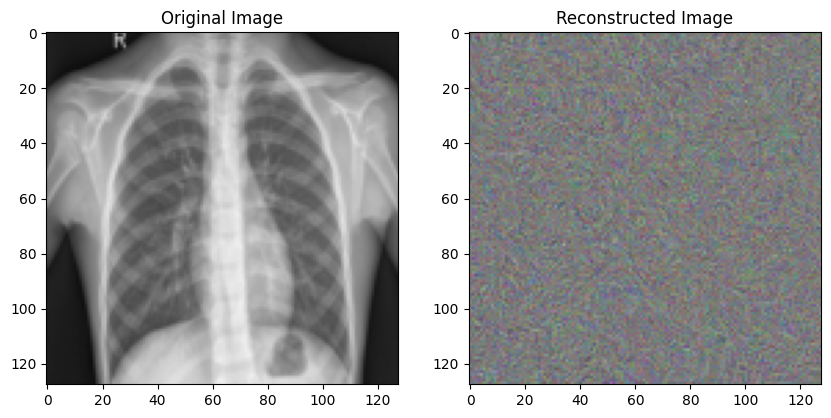

In [ ]:
def model_inversion_attack(model, dataloader, device, dataset_mean):
    model.eval()
    test_image, _ = next(iter(dataloader))  # Get a single image from the dataloader
    test_image = test_image[0].unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Check if dataset_mean is only channels and adjust
    if dataset_mean.dim() == 1:
        dataset_mean = dataset_mean.view(1, 3, 1, 1).to(device)  # Move and reshape dataset_mean to device

    # Start with a copy of the dataset_mean but with added noise
    dummy_image = dataset_mean.clone().detach() + 0.05 * torch.randn(test_image.size(), device=device)
    dummy_image.requires_grad = True
    optimizer = optim.Adam([dummy_image], lr=0.001)
    # dummy_image = test_image.clone().detach() + 0.3 * torch.randn(test_image.size()).to(device)
    # dummy_image.requires_grad = True
    # optimizer = optim.Adam([dummy_image], lr=0.001)

    # Define loss function - feature matching or perceptual loss can be used here
    loss_fn = nn.MSELoss()

    # Perform optimization
    num_steps = 1000  # Increase the number of optimization steps
    for step in range(num_steps):
        optimizer.zero_grad()
        # real_features = model.features(test_image)
        # dummy_features = model.features(dummy_image)
        real_features = model._module.features(test_image)
        dummy_features = model._module.features(dummy_image)

        loss = loss_fn(dummy_features, real_features)
        loss.backward()
        optimizer.step()

        # Clamp the values of the dummy image to ensure they are valid pixel values
        dummy_image.data.clamp_(0, 1)

        if step % 50 == 0:
            print(f'Step {step}, Loss: {loss.item()}')
    # Convert tensors to images and display
    original_img = test_image[0].detach().cpu().permute(1, 2, 0).numpy()
    reconstructed_img = dummy_image[0].detach().cpu().permute(1, 2, 0).numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title('Reconstructed Image')
    plt.show()

# Make sure to move mean to device before calling the function
mean = mean.to(device)  # Adjust this line to where mean is originally defined
model_inversion_attack(model, test_loader, device, mean)


Step 0, Loss: 0.02334180288016796
Step 50, Loss: 0.009625466540455818
Step 100, Loss: 0.0030023357830941677
Step 150, Loss: 0.0016584998229518533
Step 200, Loss: 0.0012607238022610545
Step 250, Loss: 0.0009599406039342284
Step 300, Loss: 0.0007986780256032944
Step 350, Loss: 0.0007247565081343055
Step 400, Loss: 0.0006747398292645812
Step 450, Loss: 0.0006315005011856556
Step 500, Loss: 0.0006005397299304605
Step 550, Loss: 0.0005754318553954363
Step 600, Loss: 0.000553851539734751
Step 650, Loss: 0.0005361505900509655
Step 700, Loss: 0.0005203663604333997
Step 750, Loss: 0.0005059855175204575
Step 800, Loss: 0.0004933010204695165
Step 850, Loss: 0.00048246202641166747
Step 900, Loss: 0.0004728155327029526
Step 950, Loss: 0.000464049429865554


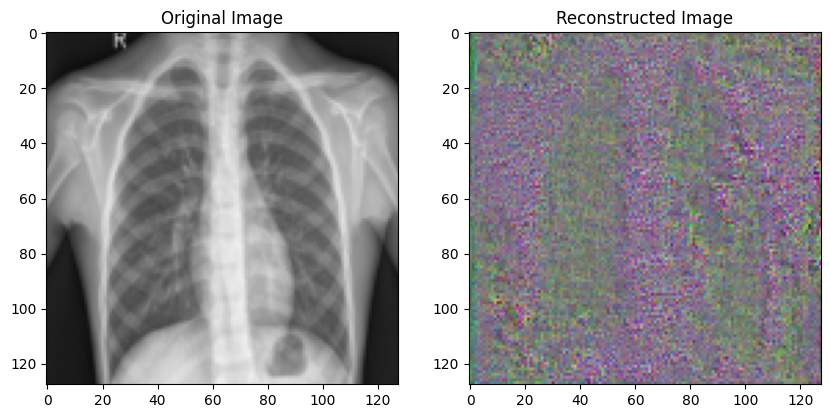

In [ ]:
def model_inversion_attack(model, dataloader, device, dataset_mean):
    model.eval()
    test_image, _ = next(iter(dataloader))  # Get a single image from the dataloader
    test_image = test_image[0].unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Check if dataset_mean is only channels and adjust
    if dataset_mean.dim() == 1:
        dataset_mean = dataset_mean.view(1, 3, 1, 1).to(device)  # Move and reshape dataset_mean to device

    # Start with a copy of the dataset_mean but with added noise
    dummy_image = dataset_mean.clone().detach() + 0.05 * torch.randn(test_image.size(), device=device)
    dummy_image.requires_grad = True
    optimizer = optim.Adam([dummy_image], lr=0.001)
    # dummy_image = test_image.clone().detach() + 0.3 * torch.randn(test_image.size()).to(device)
    # dummy_image.requires_grad = True
    # optimizer = optim.Adam([dummy_image], lr=0.001)

    # Define loss function - feature matching or perceptual loss can be used here
    loss_fn = nn.MSELoss()

    # Perform optimization
    num_steps = 1000  # Increase the number of optimization steps
    for step in range(num_steps):
        optimizer.zero_grad()
        real_features = model.features(test_image)
        dummy_features = model.features(dummy_image)
        # real_features = model._module.features(test_image)
        # dummy_features = model._module.features(dummy_image)

        loss = loss_fn(dummy_features, real_features)
        loss.backward()
        optimizer.step()

        # Clamp the values of the dummy image to ensure they are valid pixel values
        dummy_image.data.clamp_(0, 1)

        if step % 50 == 0:
            print(f'Step {step}, Loss: {loss.item()}')
    # Convert tensors to images and display
    original_img = test_image[0].detach().cpu().permute(1, 2, 0).numpy()
    reconstructed_img = dummy_image[0].detach().cpu().permute(1, 2, 0).numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title('Reconstructed Image')
    plt.show()

# Make sure to move mean to device before calling the function
mean = mean.to(device)  # Adjust this line to where mean is originally defined
model_inversion_attack(model, test_loader, device, mean)


Step 0, Loss: 2.0994722843170166
Step 50, Loss: 0.8130823373794556
Step 100, Loss: 0.6303724050521851
Step 150, Loss: 0.4138460159301758
Step 200, Loss: 0.3446826636791229
Step 250, Loss: 0.30892911553382874
Step 300, Loss: 0.29081404209136963
Step 350, Loss: 0.2765878438949585
Step 400, Loss: 0.26613718271255493
Step 450, Loss: 0.2581143379211426
Step 500, Loss: 0.2435363084077835
Step 550, Loss: 0.2263055145740509
Step 600, Loss: 0.21396282315254211
Step 650, Loss: 0.20987015962600708
Step 700, Loss: 0.19328376650810242
Step 750, Loss: 0.19300460815429688
Step 800, Loss: 0.18021155893802643
Step 850, Loss: 0.1762186735868454
Step 900, Loss: 0.17154768109321594
Step 950, Loss: 0.16715779900550842


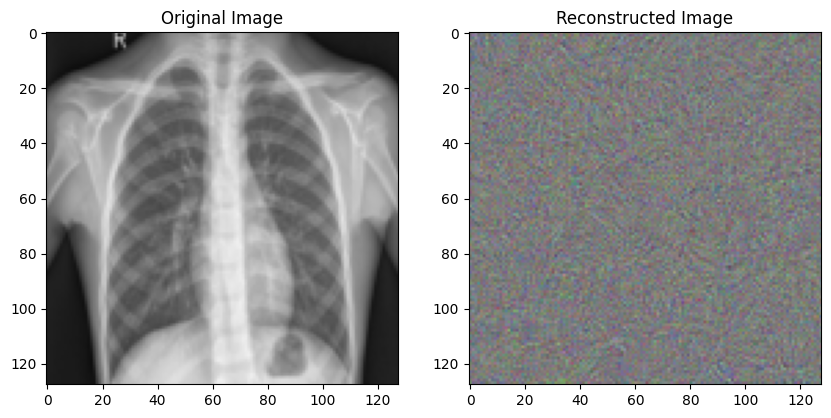

In [ ]:
import matplotlib.pyplot as plt
def model_inversion_attack(model, dataloader, device, dataset_mean):
    model.eval()
    test_image, _ = next(iter(dataloader))  # Get a single image from the dataloader
    test_image = test_image[0].unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Check if dataset_mean is only channels and adjust
    if dataset_mean.dim() == 1:
        dataset_mean = dataset_mean.view(1, 3, 1, 1).to(device)  # Move and reshape dataset_mean to device

    # Start with a copy of the dataset_mean but with added noise
    dummy_image = dataset_mean.clone().detach() + 0.05 * torch.randn(test_image.size(), device=device)
    dummy_image.requires_grad = True
    optimizer = torch.optim.Adam([dummy_image], lr=0.001)
    # dummy_image = test_image.clone().detach() + 0.3 * torch.randn(test_image.size()).to(device)
    # dummy_image.requires_grad = True
    # optimizer = optim.Adam([dummy_image], lr=0.001)

    # Define loss function - feature matching or perceptual loss can be used here
    loss_fn = nn.MSELoss()

    # Perform optimization
    num_steps = 1000  # Increase the number of optimization steps
    for step in range(num_steps):
        optimizer.zero_grad()
        # real_features = model.features(test_image)
        # dummy_features = model.features(dummy_image)
        real_features = model._module.features(test_image)
        dummy_features = model._module.features(dummy_image)

        loss = loss_fn(dummy_features, real_features)
        loss.backward()
        optimizer.step()

        # Clamp the values of the dummy image to ensure they are valid pixel values
        dummy_image.data.clamp_(0, 1)

        if step % 50 == 0:
            print(f'Step {step}, Loss: {loss.item()}')
    # Convert tensors to images and display
    original_img = test_image[0].detach().cpu().permute(1, 2, 0).numpy()
    reconstructed_img = dummy_image[0].detach().cpu().permute(1, 2, 0).numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title('Reconstructed Image')
    plt.show()

# Make sure to move mean to device before calling the function
mean = mean.to(device)  # Adjust this line to where mean is originally defined
model_inversion_attack(model, test_loader, device, mean)
